In [36]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import seaborn as sns
# from cdo import *
# cdo = Cdo()

from scipy.stats import linregress

dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

In [37]:
def flip_lon_tll(da):
    # flip 360 to 180 lon
    # for time-lat-lon xarray dataarray

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]
    time_da = da.coords["time"]

    # flip lon
    lon_180 = (lon_da.values + 180) % 360 - 180

    # new data array
    da_180 = xr.DataArray(da.values,
                          coords=[time_da,lat_da.values,lon_180],
                          dims=["time","lat","lon"])

    # flip dataarray so it goes from -180 to 180
    # (instead of 0-180, -180-0)
    lon_min_neg = np.amin(lon_180[lon_180<0])
    lon_max_neg = np.amax(lon_180[lon_180<0])
    lon_min_pos = np.amin(lon_180[lon_180>=0])
    lon_max_pos = np.amax(lon_180[lon_180>=0])
    da_180_flip = xr.concat([da_180.loc[:,:,lon_min_neg:lon_max_neg],
                             da_180.loc[:,:,lon_min_pos:lon_max_pos]],
                            dim="lon")
    return(da_180_flip)

In [38]:
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
# display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.roll(lon=len(tas_CRUTEMP.lon)//2, roll_coords=True)
tas_CRUTEMP['lon'] = np.where(tas_CRUTEMP['lon']> 180, tas_CRUTEMP['lon']-360, tas_CRUTEMP['lon'])
print(tas_CRUTEMP)

tas_MLOST = tas_MLOST.roll(lon=len(tas_MLOST.lon)//2, roll_coords=True)
tas_MLOST['lon'] = np.where(tas_MLOST['lon']> 180, tas_MLOST['lon']-360, tas_MLOST['lon'])
print(tas_MLOST)

<xarray.Dataset>
Dimensions:    (time: 2078, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    comment:      CRUTEM5 air temperature at 2m
    history:      Wed May 24 15:21:38 2023: cdo remapbil,r180x90 /work/mh0033...
    licence:      CRUTEM5 is licensed under the Open Government Licence v3.0 ...
    reference:    Osborn, T. J., P. D. Jones, D. H. Lister, C. P. Morice, I. ...
    source:      

In [39]:
tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
tas_CRUTEMP = tas_CRUTEMP-273.15
# tas_GHCNv4  = tas_GHCNv4-273.15
# tas_MLOST_sel = tas_MLOST_sel-273.15
display(tas_CRUTEMP)

<xarray.Dataset>
Dimensions:    (time: 2078, lon: 180, lat: 90, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2023-02-15
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 -3.785e+18 -3.784e+18 ... 1.678e+18
    tas        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    comment:      CRUTEM5 air temperature at 2m
    history:      Wed May 24 15:21:38 2023: cdo remapbil,r180x90 /work/mh0033...
    licence:      CRUTEM5 is licensed under the Open Government Licence v3.0 ...
    reference:    Osborn, T. J., P. D. Jones, D. H. Lister, C. P. Morice, I. ...
    source:       
    title:        CRUTEM5 air temperature over land
    version:      CRUTEM.5.0.1.0
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [40]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [41]:
tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 -0.1569 -0.1569 -0.1418 ... 5.342 5.45
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [42]:
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)
# land_sea_mask.coords
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = tas_MLOST.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_tas

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lat: 90, lon: 91)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 180.0 0.0 2.0 4.0 6.0 ... 172.0 174.0 176.0 178.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) float64 1.826e+04 1.826e+04 ... nan nan
    air        (time, lat, lon) float32 -0.1569 -0.1726 -0.1726 ... nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [43]:
tas_GISS_annual    = tas_GISS['air'].loc['1900-01-01':'2022-12-31',0:90,:]
#xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
tas_CRUTEMP_annual = tas_CRUTEMP['tas'].loc['1900-01-01':'2022-12-31',0:90,:]
tas_MLOST_annual   = masked_tas['air'].loc['1900-01-01':'2022-12-31',0:90,:]
# tas_GHCNv4_annual  = tas_GHCNv4['tempanomaly'].loc['1900-01-01':'2014-12-01',0:90,:]

tas_GISS_ano     = tas_GISS_annual-tas_GISS_annual.mean()
tas_CRUTEMP_ano  = tas_CRUTEMP_annual-tas_CRUTEMP_annual.mean()
tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()
# tas_GHCNv4_ano   = tas_GHCNv4_annual-tas_GHCNv4_annual.mean()

year = np.arange(1900,2015,1)
lat = tas_CRUTEMP['lat']
lon = tas_CRUTEMP['lon']

# print(tas_GISS_ano)
# print(tas_MLOST_ano)
print(tas_CRUTEMP_ano)

<xarray.DataArray 'tas' (time: 1476, lat: 45, lon: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..

In [44]:
#monthly data arrange
tas_GISS_monthly_data = tas_GISS_ano.resample(time='1M').mean()
tas_GISS_monthly_data['time']= pd.to_datetime(tas_GISS_monthly_data['time'].values)
tas_GISS_monthly_Grouped = tas_GISS_monthly_data.groupby('time.month')

tas_GISS_monthly_Grouped

tas_monthly_GISS_arrays=[]
for month, group in tas_GISS_monthly_Grouped:
    tas_monthly_GISS_arrays.append(group.values)
    
# print(tas_monthly_arrays)
month = xr.DataArray(np.arange(1,13,1), dims='month')
year = xr.DataArray(np.arange(1900, 2023,1), dims='year')
lat = xr.DataArray(np.arange(1,91,2), dims='lat')
lon = xr.DataArray(np.arange(-178,182,2), dims='lon')
new_dims = {'month': month, 'year': year, 'lat': lat, 'lon': lon}

tas_monthly_GISS = xr.DataArray(tas_monthly_GISS_arrays, dims=('month','year','lat','lon'), coords=new_dims)
tas_monthly_GISS = tas_monthly_GISS.assign_coords(year=pd.to_datetime(tas_monthly_GISS.year, format='%Y'))
print(tas_monthly_GISS)
tas_monthly_GISS.values

<xarray.DataArray (month: 12, year: 123, lat: 45, lon: 180)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [       nan,        nan,    

array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,    

In [45]:
tas_MLOST_monthly_data = tas_MLOST_ano.resample(time='1M').mean()
tas_MLOST_monthly_data['time']= pd.to_datetime(tas_MLOST_monthly_data['time'].values)
tas_MLOST_monthly_Grouped = tas_MLOST_monthly_data.groupby('time.month')

tas_MLOST_monthly_Grouped

tas_monthly_MLOST_arrays=[]
for month, group in tas_MLOST_monthly_Grouped:
    tas_monthly_MLOST_arrays.append(group.values)
    
# print(tas_monthly_arrays)
month = xr.DataArray(np.arange(1,13,1), dims='month')
year = xr.DataArray(np.arange(1900, 2023,1), dims='year')
lat = xr.DataArray(np.arange(1,91,2), dims='lat')
lon = xr.DataArray(np.arange(0,182,2), dims='lon')
new_dims = {'month': month, 'year': year, 'lat': lat, 'lon': lon}

tas_monthly_MLOST = xr.DataArray(tas_monthly_MLOST_arrays, dims=('month','year','lat','lon'), coords=new_dims)
tas_monthly_MLOST = tas_monthly_MLOST.assign_coords(year=pd.to_datetime(tas_monthly_MLOST.year, format='%Y'))
print(tas_monthly_MLOST)

<xarray.DataArray (month: 12, year: 123, lat: 45, lon: 91)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],


In [46]:
tas_CRUTEMP_monthly_data = tas_CRUTEMP_ano.resample(time='1M').mean()
tas_CRUTEMP_monthly_data['time']= pd.to_datetime(tas_CRUTEMP_monthly_data['time'].values)
tas_CRUTEMP_monthly_Grouped = tas_CRUTEMP_monthly_data.groupby('time.month')
tas_CRUTEMP_monthly_Grouped

tas_monthly_CRUTEMP_arrays=[]
for month, group in tas_CRUTEMP_monthly_Grouped:
    tas_monthly_CRUTEMP_arrays.append(group.values)
    
# print(tas_monthly_arrays)
month = xr.DataArray(np.arange(1,13,1), dims='month')
year = xr.DataArray(np.arange(1900, 2023,1), dims='year')
lat = xr.DataArray(np.arange(1,91,2), dims='lat')
lon = xr.DataArray(np.arange(-178,182,2), dims='lon')
new_dims = {'month': month, 'year': year, 'lat': lat, 'lon': lon}

tas_monthly_CRUTEMP = xr.DataArray(tas_monthly_CRUTEMP_arrays, dims=('month','year','lat','lon'), coords=new_dims)
tas_monthly_CRUTEMP = tas_monthly_CRUTEMP.assign_coords(year=pd.to_datetime(tas_monthly_CRUTEMP.year, format='%Y'))
print(tas_monthly_CRUTEMP)

<xarray.DataArray (month: 12, year: 123, lat: 45, lon: 180)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],

In [47]:
len(np.arange(-180,180,2))
len(np.arange(1,91,2))

45

In [48]:
# tas_monthly_CRUTEMP_arrays=[]
# for month, group in tas_CRUTEMP_monthly_Grouped:
#     tas_monthly_CRUTEMP_arrays.append(group.values)
    
# # Reshape the input data array to match the desired dimensions
# reshaped_data = np.reshape(tas_monthly_CRUTEMP_arrays, (12, -1, 45, 180))

# # Create the new dimensions and coordinates
# new_dims = {'month': range(1, 13), 'year': range(1900, 2014), 'lat': tas_monthly_CRUTEMP.lat, 'lon': tas_monthly_CRUTEMP.lon}

# # Create the new DataArray with proper dimensions and coordinates
# tas_monthly_CRUTEMP = xr.DataArray(reshaped_data, dims=('month', 'year', 'lat', 'lon'), coords=new_dims)
# tas_monthly_CRUTEMP = tas_monthly_CRUTEMP.assign_coords(year=pd.to_datetime(tas_monthly_CRUTEMP.year, format='%Y'))
# print(tas_monthly_CRUTEMP)

In [120]:
import statsmodels.api as sm

# Calculate the Northern Hemisphere averaged SAT anomalies
nh_mean_anomalies = tas_monthly_MLOST.mean(dim=['lat', 'lon'])
nh_mean_anomalies

<xarray.DataArray (month: 12, year: 123)>
array([[-3.1198468 , -1.3096552 , -0.6561575 , ...,  3.1947012 ,
         0.10512219,  2.1805665 ],
       [-1.4924057 , -0.04847632,  0.197429  , ...,  3.7326133 ,
         0.76281637,  2.1765249 ],
       [-0.30190507,  0.4642662 , -1.5056055 , ...,  3.1688006 ,
         1.449051  ,  1.9048688 ],
       ...,
       [ 0.0439016 , -0.9988115 , -1.5107441 , ...,  1.7095895 ,
         1.5250585 ,  1.9778976 ],
       [-0.31765968, -0.18586957, -2.1750937 , ...,  2.8530254 ,
         2.0676188 ,  1.310073  ],
       [-0.7874265 , -2.2737818 , -1.5157559 , ...,  0.6670192 ,
         0.7761967 ,  1.0072315 ]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) datetime64[ns] 1900-01-01 1901-01-01 ... 2022-01-01

In [121]:
nh_mean_select = nh_mean_anomalies.sel(year=nh_mean_anomalies.year.dt.year.isin(np.arange(1958, 2023,1)))
type(nh_mean_anomalies)
nh_mean_anomalies

<xarray.DataArray (month: 12, year: 123)>
array([[-3.1198468 , -1.3096552 , -0.6561575 , ...,  3.1947012 ,
         0.10512219,  2.1805665 ],
       [-1.4924057 , -0.04847632,  0.197429  , ...,  3.7326133 ,
         0.76281637,  2.1765249 ],
       [-0.30190507,  0.4642662 , -1.5056055 , ...,  3.1688006 ,
         1.449051  ,  1.9048688 ],
       ...,
       [ 0.0439016 , -0.9988115 , -1.5107441 , ...,  1.7095895 ,
         1.5250585 ,  1.9778976 ],
       [-0.31765968, -0.18586957, -2.1750937 , ...,  2.8530254 ,
         2.0676188 ,  1.310073  ],
       [-0.7874265 , -2.2737818 , -1.5157559 , ...,  0.6670192 ,
         0.7761967 ,  1.0072315 ]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) datetime64[ns] 1900-01-01 1901-01-01 ... 2022-01-01

In [122]:
# Convert the xarray DataArray to a pandas DataFrame for easier manipulation
df = nh_mean_anomalies.to_dataframe(name='SAT Anomaly (C)')
display(df)
# Convert the index to a DatetimeIndex
# df.index = pd.to_datetime(df.index, format="'(Timestamp('%Y-%m-%d %H:%M:%S'))'")
df.loc[(1,)]

# Calculate the trend for each month separately
month_trends = []
for month in range(1, 13):
    monthly_data = df.loc[(month,)]
    monthly_trends = []
    for start_year in range(1958, 2009):
        end_year = start_year + 14
        start_date = pd.to_datetime(f"{start_year}-{month}-01")
        end_date = pd.to_datetime(f"{end_year}-{month}-01")
        yearly_data = monthly_data.loc[(monthly_data.index >= start_date) & (monthly_data.index < end_date)]
        trend = yearly_data.apply(
            lambda x: sm.OLS(x, sm.add_constant(np.arange(len(x)))).fit().params[1],
            axis=0
        )
        monthly_trends.append(trend)
    month_trends.append(monthly_trends)

# Combine the monthly trends into a single DataFrame
trends_df = pd.concat([pd.concat([month_trends[i][j] for j in range(len(month_trends[i]))], axis=1, keys=range(1958, 2024)) for i in range(12)], axis=0)
trends_df
type(trends_df)

SAT Anomaly (C)
month year                       
1     1900-01-01        -3.119847
      1901-01-01        -1.309655
      1902-01-01        -0.656157
      1903-01-01        -0.405251
      1904-01-01        -0.759369
...                           ...
12    2018-01-01         0.544418
      2019-01-01         1.717723
      2020-01-01         0.667019
      2021-01-01         0.776197
      2022-01-01         1.007231

[1476 rows x 1 columns]

pandas.core.frame.DataFrame

In [123]:
# trends_df.to_csv('trends_df.csv')

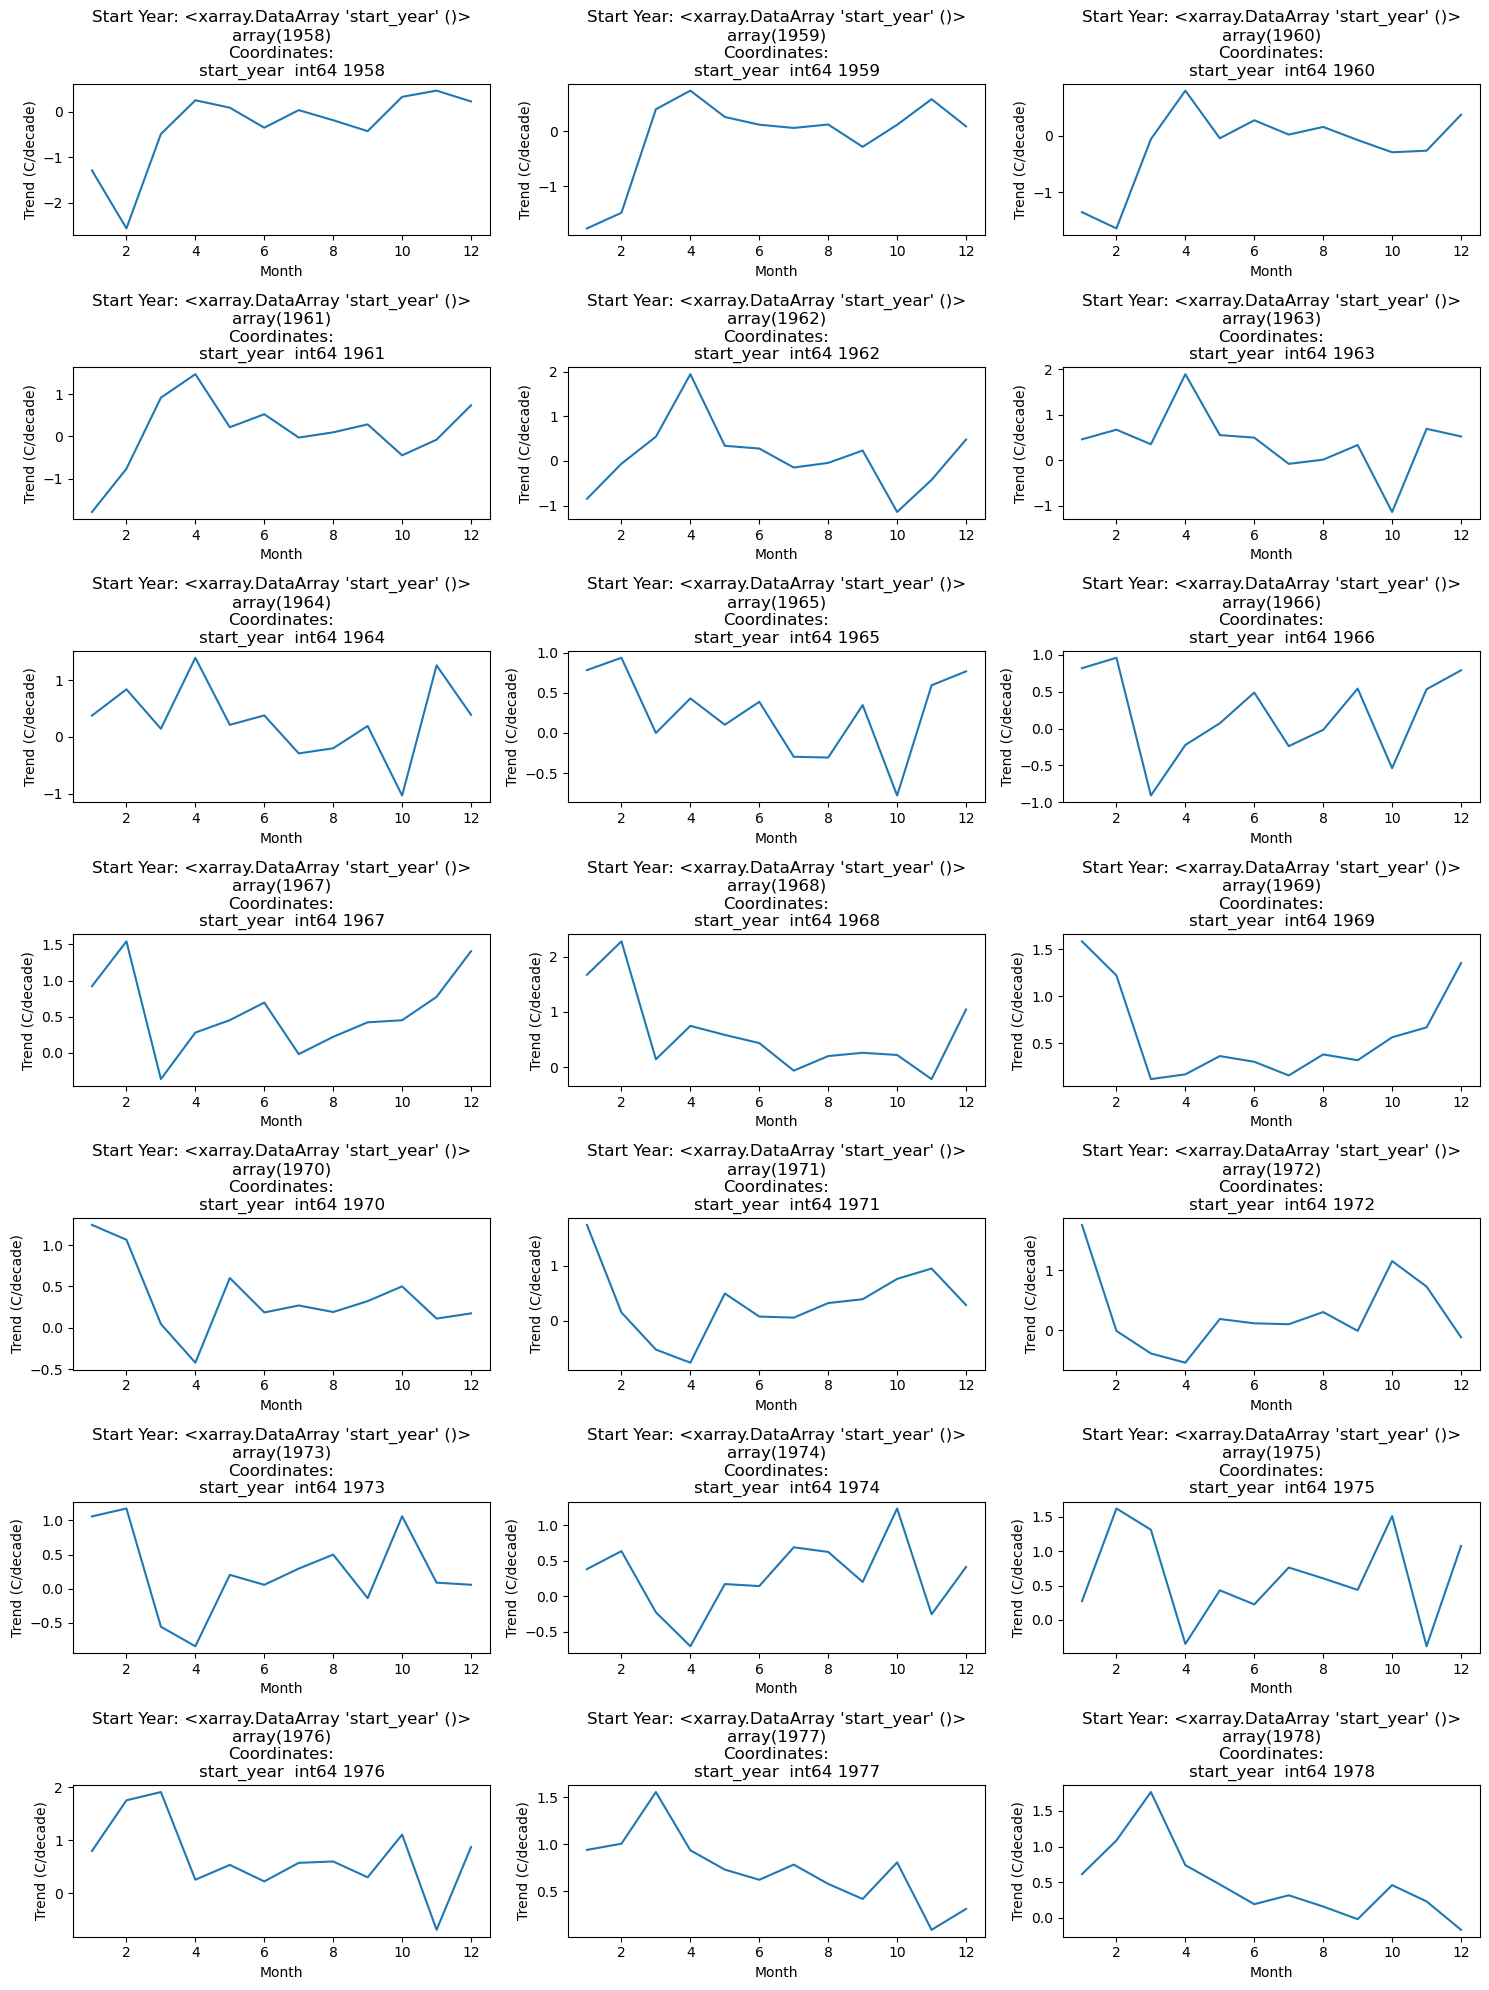

In [124]:
# Convert the pandas DataFrame back to an xarray DataArray with proper time and month coordinates
trends_da = xr.DataArray(
    trends_df.values,
    coords=[range(1, 13), range(1958, 2009)],
    dims=['month','start_year']
)

# Set the attributes of the trend DataArray
# trends_da.attrs = nh_mean_anomalies.attrs

# Multiply the trends by 15
trends_da = trends_da * 15.0
trends_da
import matplotlib.pyplot as plt

# Create a separate subplot for each start year value
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

# Plot the trends_da DataArray in each subplot
for i, ax in enumerate(axs.flat):
    if i < len(trends_da.start_year):
        ax.plot(range(1, 13), trends_da.sel(start_year=trends_da.start_year[i]))
        ax.set_xlabel('Month')
        ax.set_ylabel('Trend (C/decade)')
        ax.set_title(f"Start Year: {trends_da.start_year[i]}")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [126]:
imonth = trends_da.month.values.repeat(51)
iyear = np.tile(trends_da.start_year.values, 12)
trenddata = trends_da.values.flatten()
data = dict(month=imonth, year=iyear, trend=trenddata)
df = pd.DataFrame(data=data)
df

,month,year,trend
0,1,1958,-1.291894
1,1,1959,-1.761606
2,1,1960,-1.347778
3,1,1961,-1.782341
4,1,1962,-0.849535
...,...,...,...
607,12,2004,0.526019
608,12,2005,0.775917
609,12,2006,0.943660
610,12,2007,1.152284


In [127]:
# trends_da.name = 'Trend (C/decade)'
# trends_df = trends_da.to_dataframe()
# display(trends_df)

df.to_csv('./15yr_running_MLOST_NH_LSAT_trend.csv')
